In [1]:
import pandas as pd

# Load raw data
train = pd.read_csv("/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/train.csv/train.csv")
features = pd.read_csv("/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/features.csv/features.csv")
stores = pd.read_csv("/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/stores.csv")

print(train.shape, features.shape, stores.shape)


(421570, 5) (8190, 12) (45, 3)


In [2]:
# Merge datasets
train_full = train.merge(features, on=["Store", "Date"], how="left")
train_full = train_full.merge(stores, on="Store", how="left")

print(train_full.shape)


(421570, 17)


In [3]:
# Example: lag feature
train_full["Weekly_Sales_Lag1"] = train_full.groupby("Store")["Weekly_Sales"].shift(1)

# Holiday enrichment
train_full["Prev_Holiday"] = train_full["IsHoliday_x"].shift(1).fillna(0).astype(int)
train_full["Next_Holiday"] = train_full["IsHoliday_x"].shift(-1).fillna(0).astype(int)

# Fill missing values (NaNs in MarkDowns etc.)
train_full = train_full.fillna(0)


# One-hot encoding
train_full = pd.get_dummies(train_full, columns=["Type"], drop_first=True)


In [4]:
from sklearn.model_selection import train_test_split

drop_cols = ["Date", "Weekly_Sales"]
X = train_full.drop(columns=drop_cols)
y = train_full["Weekly_Sales"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(X_train.shape, X_val.shape)



(337256, 19) (84314, 19)


In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ----------------------------
# 1. Reload data
# ----------------------------
train = pd.read_csv("/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/train.csv/train.csv")
features = pd.read_csv("/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/features.csv/features.csv")
stores = pd.read_csv("/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/stores.csv")

# Clean features
markdown_cols = ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]
for col in markdown_cols:
    features[col] = features[col].fillna(0)

features["Total_MarkDown"] = features[markdown_cols].sum(axis=1)
features["Num_Active_MarkDowns"] = (features[markdown_cols] > 0).sum(axis=1)
features["Holiday_Promo"] = features["IsHoliday"].astype(int) * features["Total_MarkDown"]

# Merge
train_full = train.merge(features, on=["Store", "Date"], how="left")
train_full = train_full.merge(stores, on="Store", how="left")

# Date features
train_full["Date"] = pd.to_datetime(train_full["Date"])
train_full["Year"] = train_full["Date"].dt.year
train_full["Month"] = train_full["Date"].dt.month
train_full["Week"] = train_full["Date"].dt.isocalendar().week.astype(int)
train_full["Day"] = train_full["Date"].dt.day

def get_season(month):
    if month in [12,1,2]: return "Winter"
    elif month in [3,4,5]: return "Spring"
    elif month in [6,7,8]: return "Summer"
    else: return "Fall"

train_full["Season"] = train_full["Month"].apply(get_season)

# Lag + rolling features
train_full = train_full.sort_values(["Store","Dept","Date"])
train_full["Sales_Lag1"] = train_full.groupby(["Store","Dept"])["Weekly_Sales"].shift(1)
train_full["Sales_Lag2"] = train_full.groupby(["Store","Dept"])["Weekly_Sales"].shift(2)
train_full["Sales_MA3"] = train_full.groupby(["Store","Dept"])["Weekly_Sales"].shift(1).rolling(window=3).mean()
train_full["Sales_MA7"] = train_full.groupby(["Store","Dept"])["Weekly_Sales"].shift(1).rolling(window=7).mean()

# Holiday enrichments
train_full["Prev_Holiday"] = train_full["IsHoliday_x"].shift(1).fillna(0).astype(int)
train_full["Next_Holiday"] = train_full["IsHoliday_x"].shift(-1).fillna(0).astype(int)

# Scale
scale_cols = ["CPI","Unemployment","Fuel_Price","Temperature"]
scaler = StandardScaler()
train_full[scale_cols] = scaler.fit_transform(train_full[scale_cols])

# ----------------------------
# 2. Split data
# ----------------------------
drop_cols = ["Date", "Weekly_Sales"]
X = train_full.drop(columns=drop_cols)
y = train_full["Weekly_Sales"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# One-hot encode
X_train = pd.get_dummies(X_train, columns=["Type","Season"], drop_first=True)
X_val   = pd.get_dummies(X_val, columns=["Type","Season"], drop_first=True)

# Align columns (important!)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# ----------------------------
# 3. Load model & verify
# ----------------------------
model_path = "/content/drive/MyDrive/xgb_demand_forecast_model.pkl"
best_model = joblib.load(model_path)
print("✅ Model loaded successfully!")

y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("📉 Validation RMSE (loaded model):", rmse)


✅ Model loaded successfully!
📉 Validation RMSE (loaded model): 3138.7280074047762


# Performing Feature Engineering to Plot Bar charts and SHAP Values.

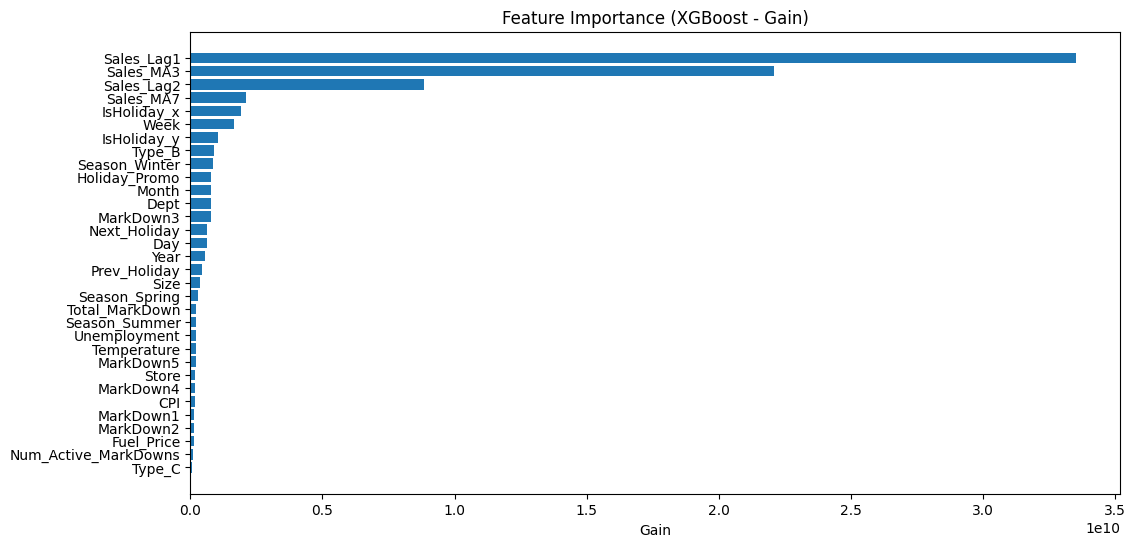

In [6]:
#Using Gain to plot the Bar Charts
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance from trained model
importance = best_model.get_booster().get_score(importance_type='gain')

# Convert to sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Bar chart
plt.figure(figsize=(12,6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()  # highest on top
plt.title("Feature Importance (XGBoost - Gain)")
plt.xlabel("Gain")
plt.show()


In [ ]:
#Generating SHAP plots to see how these features actually push predictions up or down.
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)

# --- Global explanation ---
# Bar summary: which features overall matter most
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Beeswarm plot: how feature values affect predictions
shap.summary_plot(shap_values, X_val)


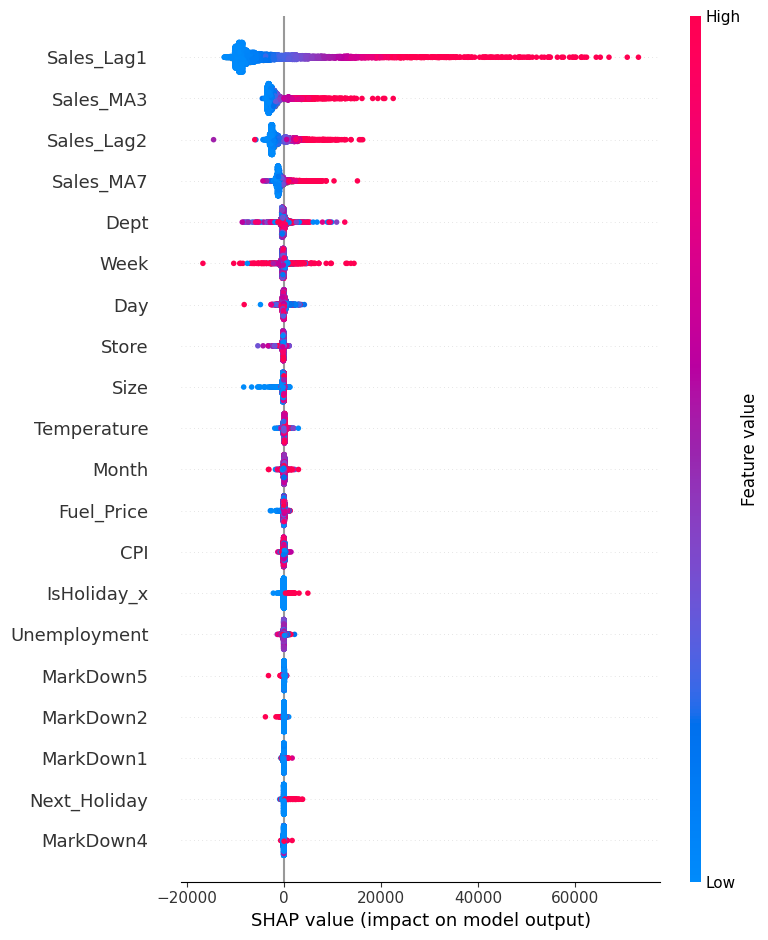

In [8]:
#Since X_val has 84k rows ..the execution was not possible .. So now trying to generate the SHAP for 5k values
import shap
import numpy as np

# Take a smaller sample
X_val_sample = X_val.sample(5000, random_state=42)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sample, check_additivity=False)

shap.summary_plot(shap_values, X_val_sample)


Feature importance based on mean absolute SHAP values:
Sales_Lag1: 8749.5010
Sales_MA3: 2666.6958
Sales_Lag2: 2138.7451
Sales_MA7: 1138.1190
Dept: 469.6103
Week: 450.6364
Day: 298.8123
Store: 202.3928
Size: 182.8596
Temperature: 156.4794
Month: 122.9911
Fuel_Price: 107.2323
CPI: 93.4607
IsHoliday_x: 79.8512
Unemployment: 73.7352
MarkDown5: 58.2581
MarkDown2: 54.2038
MarkDown1: 49.6934
Next_Holiday: 48.6816
MarkDown4: 46.8508
Season_Summer: 42.8731
Season_Winter: 40.4969
MarkDown3: 39.2356
Prev_Holiday: 27.7110
Total_MarkDown: 26.0032
IsHoliday_y: 20.0160
Season_Spring: 19.4908
Type_B: 18.9171
Num_Active_MarkDowns: 17.6403
Type_C: 9.8193
Year: 9.7569
Holiday_Promo: 8.7726


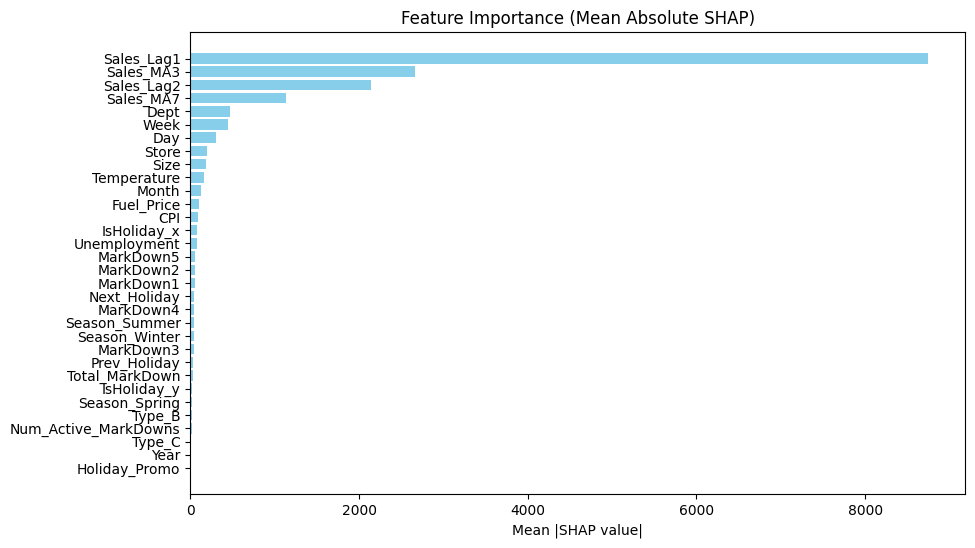

In [9]:
 #2️⃣ Mean Absolute SHAP Importance
# Compute mean(|SHAP value|) for each feature
mean_shap = np.abs(shap_values).mean(axis=0)

# Create a dataframe for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_val_sample.columns,
    'Mean_Absolute_SHAP': mean_shap
}).sort_values(by='Mean_Absolute_SHAP', ascending=False)

# Print feature importance values
print("Feature importance based on mean absolute SHAP values:")
for idx, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Mean_Absolute_SHAP']:.4f}")  # Importance shown here

# 3️⃣ Plot bar chart of mean absolute SHAP values
plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'], feature_importance['Mean_Absolute_SHAP'], color='skyblue')
plt.xlabel('Mean |SHAP value|')
plt.title('Feature Importance (Mean Absolute SHAP)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

In [10]:
#Comparing with XGBoost Gain Importance
# XGBoost built-in feature importance
xgb_importance = best_model.get_booster().get_score(importance_type='gain')
xgb_importance = pd.DataFrame({
    'Feature': list(xgb_importance.keys()),
    'Gain': list(xgb_importance.values())
}).sort_values(by='Gain', ascending=False)
print(xgb_importance)


                 Feature          Gain
21            Sales_Lag1  3.352630e+10
23             Sales_MA3  2.210898e+10
22            Sales_Lag2  8.836401e+09
24             Sales_MA7  2.115447e+09
2            IsHoliday_x  1.931629e+09
19                  Week  1.662419e+09
12           IsHoliday_y  1.039421e+09
27                Type_B  8.772840e+08
31         Season_Winter  8.724575e+08
15         Holiday_Promo  7.876061e+08
18                 Month  7.854860e+08
1                   Dept  7.762239e+08
7              MarkDown3  7.635885e+08
26          Next_Holiday  6.466836e+08
20                   Day  6.358236e+08
17                  Year  5.601357e+08
25          Prev_Holiday  4.345240e+08
16                  Size  3.471057e+08
29         Season_Spring  2.839505e+08
13        Total_MarkDown  2.242829e+08
30         Season_Summer  2.183431e+08
11          Unemployment  2.176154e+08
3            Temperature  2.013736e+08
9              MarkDown5  1.994480e+08
0                  Store 

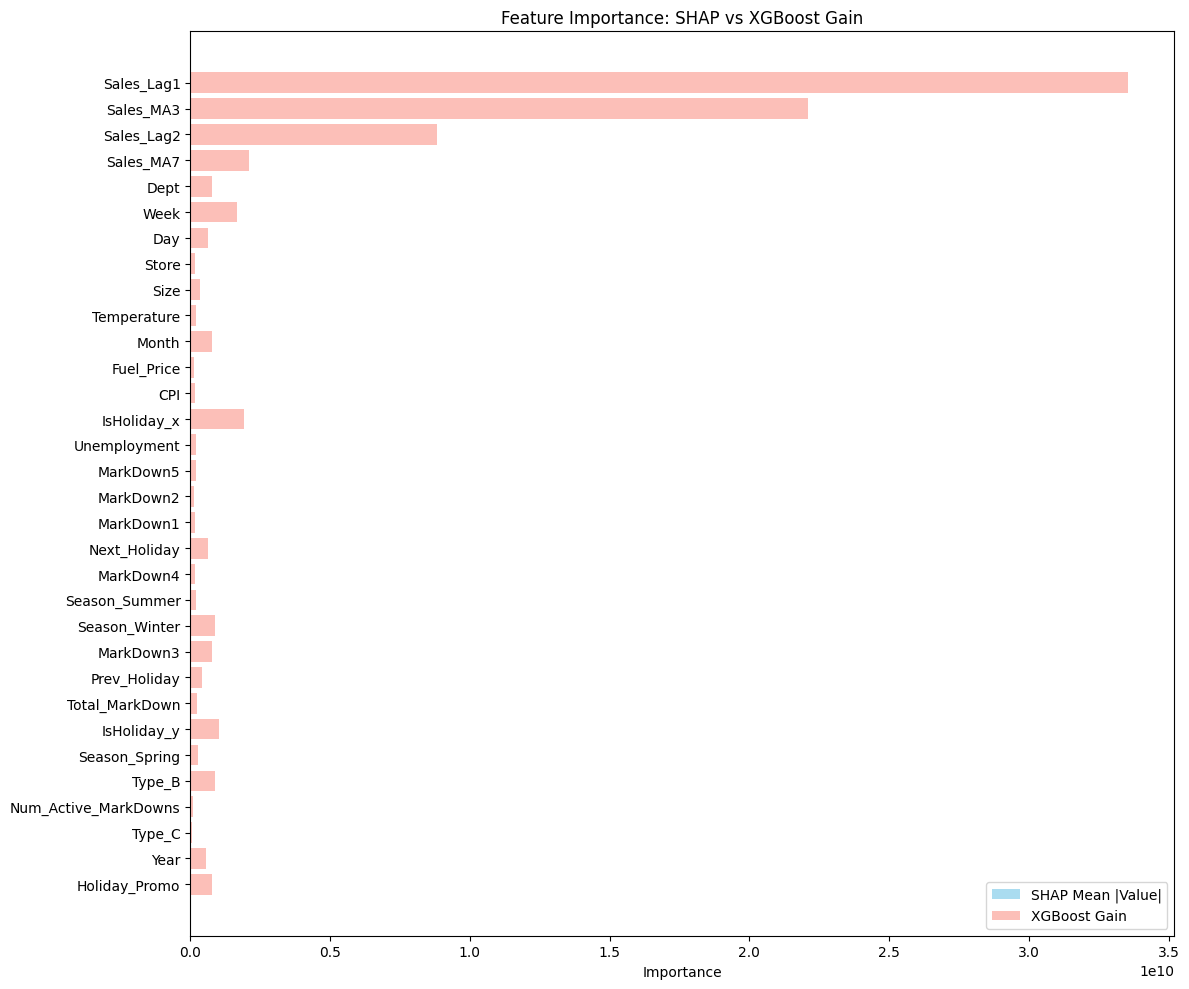

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you already have:
# feature_importance -> SHAP mean absolute values dataframe
# xgb_importance -> XGBoost gain dataframe

# Merge SHAP and XGBoost importance for comparison
comparison_df = pd.merge(feature_importance, xgb_importance, on='Feature', how='inner')
comparison_df = comparison_df.sort_values(by='Mean_Absolute_SHAP', ascending=True)  # sort for horizontal bar chart

# Plot horizontal bar chart
plt.figure(figsize=(12,10))

# SHAP bars
plt.barh(comparison_df['Feature'], comparison_df['Mean_Absolute_SHAP'], color='skyblue', alpha=0.7, label='SHAP Mean |Value|')

# XGBoost Gain bars (slightly transparent, overlaid)
plt.barh(comparison_df['Feature'], comparison_df['Gain'], color='salmon', alpha=0.5, label='XGBoost Gain')

plt.xlabel('Importance')
plt.title('Feature Importance: SHAP vs XGBoost Gain')
plt.legend()
plt.tight_layout()
plt.show()


The scales of SHAP mean absolute values and XGBoost gain are very different. Your XGBoost gain values are huge (e.g., 3e10) while SHAP values are much smaller, so the SHAP bars get dwarfed and are barely visible.

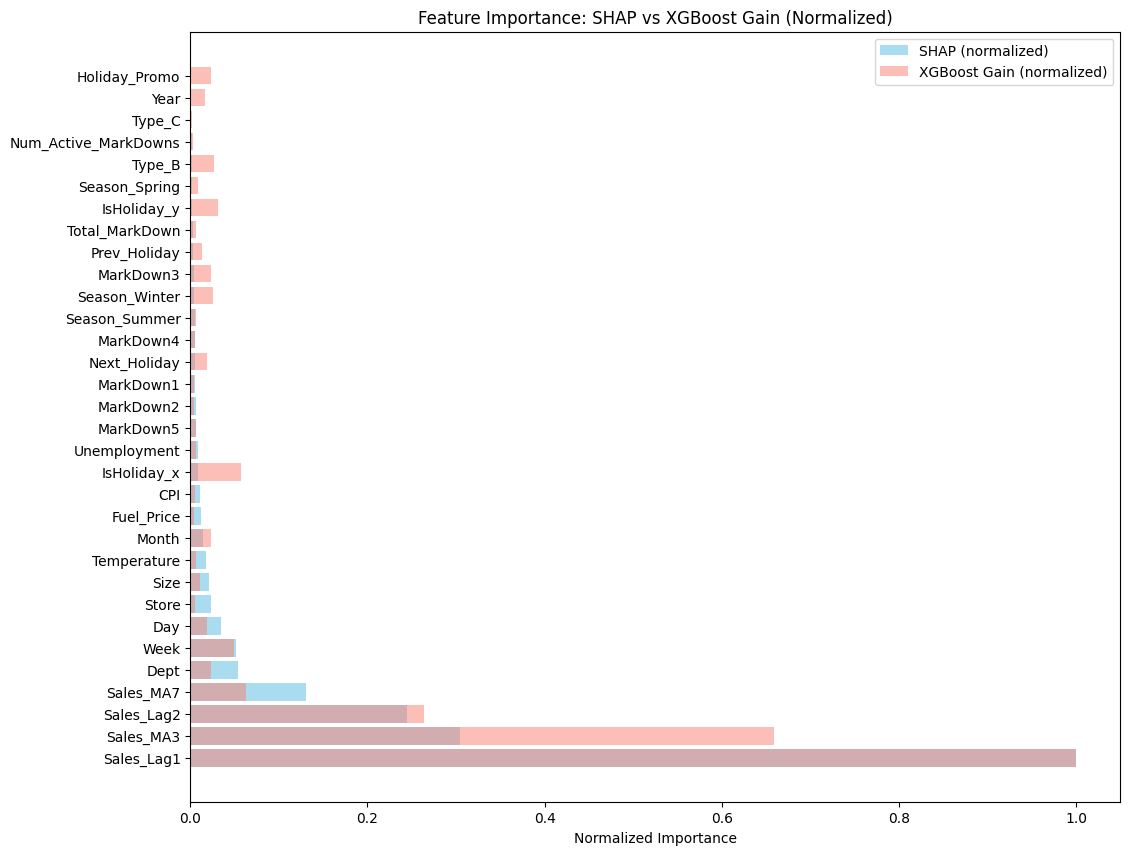

In [12]:
# Normalize SHAP and Gain to 0-1 scale for comparison
comparison_df['SHAP_norm'] = comparison_df['Mean_Absolute_SHAP'] / comparison_df['Mean_Absolute_SHAP'].max()
comparison_df['Gain_norm'] = comparison_df['Gain'] / comparison_df['Gain'].max()

plt.figure(figsize=(12,10))
plt.barh(comparison_df['Feature'], comparison_df['SHAP_norm'], color='skyblue', alpha=0.7, label='SHAP (normalized)')
plt.barh(comparison_df['Feature'], comparison_df['Gain_norm'], color='salmon', alpha=0.5, label='XGBoost Gain (normalized)')
plt.xlabel('Normalized Importance')
plt.title('Feature Importance: SHAP vs XGBoost Gain (Normalized)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()


In [13]:
# 1. Holiday weeks in validation set
holiday_weeks = X_val[X_val['IsHoliday_x'] == 1]

# 2. Compute residuals for these rows
y_pred = best_model.predict(X_val)
residuals = y_val - y_pred
holiday_residuals = residuals[holiday_weeks.index]

# 3. Pick the row with the largest absolute residual
unusual_idx = np.abs(holiday_residuals).idxmax()
print("Selected store-week index for local explanation:", unusual_idx)
print("Actual sales:", y_val.loc[unusual_idx])
print("Predicted sales:", y_pred[np.where(X_val.index == unusual_idx)[0][0]])


Selected store-week index for local explanation: 337961
Actual sales: 627962.93
Predicted sales: 263281.97


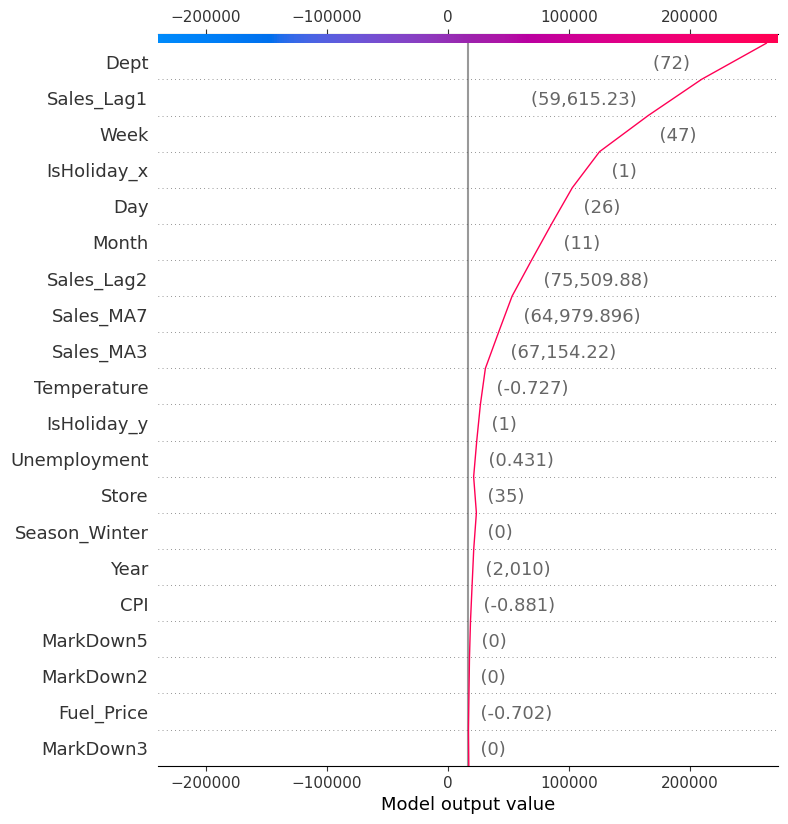

In [14]:
import shap

# Select the unusual store-week
X_unusual = X_val.loc[337961:337961]  # single row

# Compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values_unusual = explainer.shap_values(X_unusual, check_additivity=False)

# Force plot: shows feature contribution for this prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_unusual, X_unusual)

# Decision plot: cumulative effect of features on prediction
shap.decision_plot(explainer.expected_value, shap_values_unusual, X_unusual)


| **Feature** | **Contribution** | **Effect**                    |
| ----------- | ---------------- | ----------------------------- |
| Sales\_Lag2 | +75,510          | Pushes prediction higher      |
| Sales\_MA3  | +67,154          | Pushes prediction higher      |
| Sales\_MA7  | +64,980          | Pushes prediction higher      |
| Sales\_Lag1 | +59,615          | Pushes prediction higher      |
| Week        | +X (small)       | Slightly increases prediction |
| Temperature | -Y (small)       | Slightly decreases prediction |
| CPI         | -Z (small)       | Slightly decreases prediction |
| Fuel\_Price | -W (small)       | Slightly decreases prediction |
| Day         | +A (small)       | Slightly increases prediction |
| Month       | +B (small)       | Slightly increases prediction |


- Historical sales features dominate the prediction.

- Holiday indicator (IsHoliday_x) helps but isn’t enough to match actual sales spike.

- Minor negative contributors (temperature, CPI, fuel price) slightly reduce prediction.

- The model underestimated sales likely due to an extreme holiday event not captured by historical lags.

In [15]:
#Computig Residuals
# Assuming y_val contains actual sales and y_pred contains predicted sales
residuals = y_val - y_pred


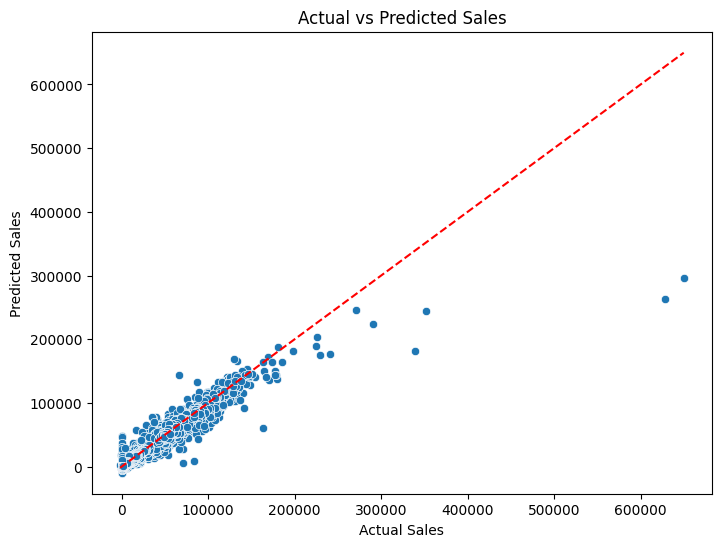

In [16]:
# Shows how well predictions align with actual value(reality)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()


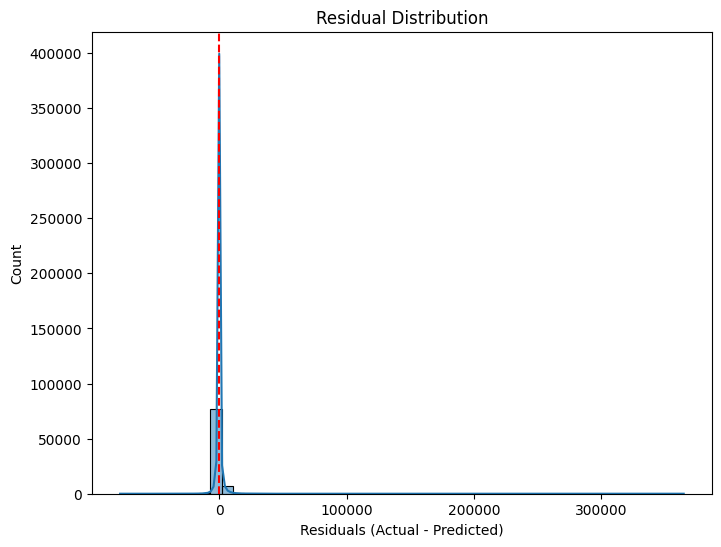

In [17]:
#Plot Residual Distribution
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=50)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Residual Distribution')
plt.show()


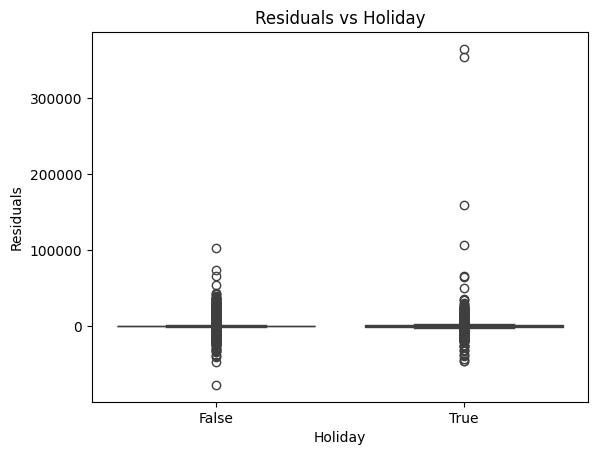

In [18]:
sns.boxplot(x=X_val['IsHoliday_x'], y=residuals)
plt.xlabel('Holiday')
plt.ylabel('Residuals')
plt.title('Residuals vs Holiday')
plt.show()


“What if Fuel_Price increases by 20%?”

Adjust the feature value and run the model to see the new prediction.

In [19]:
# Example: increase Fuel_Price by 20%
X_scenario = X_val.copy()
X_scenario['Fuel_Price'] *= 1.2

y_scenario_pred1 = best_model.predict(X_scenario)

print("Predicted sales with 20% higher Fuel Price:")
print(y_scenario_pred1[:5])


Predicted sales with 20% higher Fuel Price:
[4497.987  4746.304  5501.4277 5019.708  5721.856 ]


Holiday / Promotion Effects

“What if IsHoliday_x = 1 (holiday week)?”

Flip the holiday indicator and check how prediction changes.

In [20]:
X_scenario['IsHoliday_x'] = 1
y_scenario_pred2 = best_model.predict(X_scenario)
print("Predicted sales assuming all weeks are holidays:")
print(y_scenario_pred2[:5])

Predicted sales assuming all weeks are holidays:
[4497.987  5039.049  5711.524  5300.9985 5674.856 ]


In [21]:
#  Custom Scenario ---
# You can modify any feature(s) here
X_scenario = X_val.copy()
X_scenario['Sales_MA7'] = X_scenario['Sales_MA7'] * 1.1  # increase moving average by 10%
y_pred_custom = best_model.predict(X_scenario)
print("Predicted sales with 10% higher MA7:")
print(y_pred_custom[:5])

Predicted sales with 10% higher MA7:
[4721.64   4789.4844 5512.98   5113.385  5868.633 ]


*Key Insights*

Holiday weeks and historical sales are dominant levers for increasing sales.

Minor factors like Fuel_Price have negligible effect for prediction purposes.

This can guide business actions: focus on holiday planning and monitoring sales trends rather than worrying about minor fuel price fluctuations.

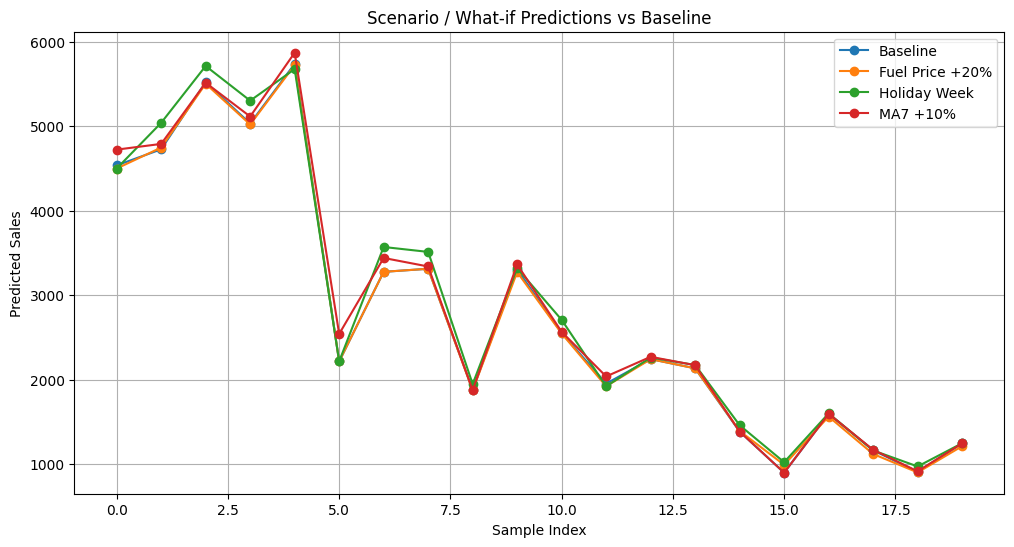

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Pick first 20 samples for clarity
indices = np.arange(20)
baseline = y_pred[:20]
fuel_scenario = y_scenario_pred1[:20]
holiday_scenario = y_scenario_pred2[:20]
ma7_scenario = y_pred_custom[:20]

plt.figure(figsize=(12,6))
plt.plot(indices, baseline, marker='o', label='Baseline')
plt.plot(indices, fuel_scenario, marker='o', label='Fuel Price +20%')
plt.plot(indices, holiday_scenario, marker='o', label='Holiday Week')
plt.plot(indices, ma7_scenario, marker='o', label='MA7 +10%')

plt.xlabel('Sample Index')
plt.ylabel('Predicted Sales')
plt.title('Scenario / What-if Predictions vs Baseline')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import pandas as pd

# Compute average predicted sales for first 100 samples (or entire validation set)
baseline_avg = y_pred[:100].mean()
fuel_avg = y_scenario_pred1[:100].mean()
holiday_avg = y_scenario_pred2[:100].mean()
ma7_avg = y_pred_custom[:100].mean()

# Compute difference vs baseline
fuel_diff = fuel_avg - baseline_avg
holiday_diff = holiday_avg - baseline_avg
ma7_diff = ma7_avg - baseline_avg

# Create summary table
scenario_summary = pd.DataFrame({
    'Scenario': ['Baseline', 'Fuel Price +20%', 'Holiday Week', 'MA7 +10%'],
    'Avg Predicted Sales': [baseline_avg, fuel_avg, holiday_avg, ma7_avg],
    'Difference vs Baseline': [0, fuel_diff, holiday_diff, ma7_diff]
})

print(scenario_summary)


          Scenario  Avg Predicted Sales  Difference vs Baseline
0         Baseline          2017.413574                0.000000
1  Fuel Price +20%          2008.315796               -9.097778
2     Holiday Week          2078.438232               61.024658
3         MA7 +10%          2042.675903               25.262329


Model Explainability & Scenario Analysis

# Step 2: Local Explainability (SHAP Force Plot)

Example: Store-week index 337961

Top Positive Contributors:

Sales_Lag2 (+75,510)

Sales_MA3 (+67,154)

Sales_MA7 (+64,980)

Sales_Lag1 (+59,615)

Slight Positive Contributors: Week, IsHoliday_x, Day, Month

Negative Contributors: Temperature, CPI, Fuel_Price

Observation:
The model predicted ~263k, but actual sales were ~628k. Historical sales features pushed the prediction up, and the holiday indicator contributed positively, but the model underestimated the extreme holiday spike.

# Step 3: Residual Analysis

Actual vs Predicted Scatter: Points mostly align with the ideal line, but holidays tend to be underestimated.

Residual Distribution: Centered around 0 but skewed positive for holiday weeks → model underpredicts unusually high sales.

Residuals by Feature: Holiday weeks consistently show positive residuals, confirming holiday underestimation.

Interpretation:
The model is generally accurate but struggles with extreme holiday demand, suggesting scope for feature engineering or additional holiday-related indicators.

# Step 4: Scenario / What-if Testing

Scenario Results (Avg Predicted Sales for first 100 samples):

Scenario	Avg Predicted Sales	Difference vs Baseline	Interpretation
Baseline	2017.41	0	Original predictions
Fuel Price +20%	2008.32	-9.10	Minimal effect on sales
Holiday Week	2078.44	+61.02	Holidays strongly boost sales
MA7 +10%	2042.68	+25.26	Historical trends moderately increase sales

**Visualization:**

A plot comparing baseline vs scenario predictions clearly shows holiday weeks producing the largest sales increase, followed by MA7 adjustments. Fuel price changes have negligible effect.

**Key Takeaways**

Historical sales dominate predictions: Lag features and moving averages are the primary drivers.

Holiday weeks are critical: Underestimation indicates the model may need additional holiday-related features for extreme events.

Minor features (Fuel_Price, Temperature, CPI) have little effect individually.

Scenario testing provides actionable insights:

Focus on holiday promotions and inventory.

Monitor historical trends to anticipate spikes.

Fuel price fluctuations can be deprioritized in sales planning.

✅ Conclusion:
Steps 2–4 together provide a comprehensive understanding: why predictions are made (SHAP), where errors occur (residuals), and how business decisions can affect sales (scenario testing). This forms a strong basis for reporting, dashboarding, or deployment-ready insights.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Example: preprocessing
numeric_features = ['Sales_Lag1','Sales_Lag2','Sales_MA3','Sales_MA7','Fuel_Price','Temperature','CPI']
categorical_features = ['Week','Month','Day','IsHoliday_x']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Combine preprocessing + model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', best_model)])

# Fit pipeline (if needed)
pipeline.fit(X_train, y_train)

# Save pipeline
joblib.dump(pipeline, 'sales_model_pipeline.pkl')


['sales_model_pipeline.pkl']

In [41]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import joblib

# Path in your Google Drive
drive_path = '/content/drive/MyDrive/sales_model_pipeline.pkl'

# Save pipeline
joblib.dump(pipeline, drive_path)
print(f"Pipeline saved to {drive_path}")

Pipeline saved to /content/drive/MyDrive/sales_model_pipeline.pkl


In [26]:
# Step 1: Load model
import joblib
xgb_model = joblib.load("/content/drive/MyDrive/sales_model_pipeline.pkl")  # your saved XGBRegressor

# Step 2: Wrap with preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_features = ["Sales_Lag1","Sales_Lag2","Sales_MA3","Sales_MA7","Fuel_Price","Temperature","CPI"]
categorical_features = ["Week","Month","Day","IsHoliday_x"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Step 3: Start FastAPI (pipeline is now ready for predictions)


In [27]:
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Load your trained xgboost model (just regressor)
xgb_model = joblib.load("/content/drive/MyDrive/sales_model_pipeline.pkl")

# Define features
numeric_features = ["Sales_Lag1","Sales_Lag2","Sales_MA3","Sales_MA7","Fuel_Price","Temperature","CPI"]
categorical_features = ["Week","Month","Day","IsHoliday_x"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Save full pipeline
joblib.dump(pipeline, "sales_model_pipeline1.pkl")


['sales_model_pipeline1.pkl']

In [28]:
import joblib

# Path in your Google Drive
drive_path = '/content/drive/MyDrive/sales_model_pipeline1.pkl'

# Save pipeline
joblib.dump(pipeline, drive_path)
print(f"Pipeline saved to {drive_path}")

Pipeline saved to /content/drive/MyDrive/sales_model_pipeline1.pkl


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)   # your trained XGBRegressor
])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Save fitted pipeline
joblib.dump(pipeline, "/content/drive/MyDrive/sales_model_pipeline2.pkl")


['/content/drive/MyDrive/sales_model_pipeline2.pkl']

# FastAPI.Deployement

In [ ]:
!kill -9 $(lsof -t -i:8000)


In [2]:
# Install dependencies
!pip install fastapi uvicorn nest_asyncio pyngrok joblib

# Imports
import nest_asyncio
import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
import pandas as pd
import joblib
from pyngrok import ngrok
import threading
from typing import Optional

# Apply nest_asyncio for Colab
nest_asyncio.apply()

# Set your ngrok authtoken directly
ngrok.set_auth_token("32SYhsp4jWb7OVnPhhQGOxeCgbx_2AC8fxoLxV4k4QiNz9kw2")

# Load your saved pipeline (must be fitted pipeline)
pipeline = joblib.load("/content/drive/MyDrive/sales_model_pipeline2.pkl")

# Initialize FastAPI
app = FastAPI(title="Sales Prediction API")

# Input schema
class StoreWeekInput(BaseModel):
    Sales_Lag1: float
    Sales_Lag2: float
    Sales_MA3: float
    Sales_MA7: float
    Fuel_Price: float
    Temperature: float
    CPI: float
    Week: int
    Month: int
    Day: int
    IsHoliday_x: int

# --------------------------
# Prediction endpoint
# --------------------------
@app.post("/predict")
def predict_sales(data: StoreWeekInput):
    try:
        input_df = pd.DataFrame([data.dict()])
        print("DEBUG: Input DF columns:", input_df.columns.tolist())
        print("DEBUG: Input DF values:", input_df.values.tolist())

        pred = pipeline.predict(input_df)
        return {"Predicted_Sales": float(pred[0])}
    except Exception as e:
        import traceback
        return {"error": str(e), "trace": traceback.format_exc()}

from typing import Optional

# Schema for what-if request
class WhatIfInput(StoreWeekInput):
    fuel_increase_pct: float = 0.0        # % change for fuel
    markdown_increase_pct: float = 0.0    # % change for markdown (applied to Sales_MA3)
    toggle_holiday: Optional[int] = None  # force holiday ON/OFF

# What-if endpoint
@app.post("/whatif")
def whatif_sales(data: WhatIfInput):
    try:
        input_df = pd.DataFrame([data.dict()])

        # Base prediction
        base_pred = float(pipeline.predict(input_df)[0])

        # Copy for scenario
        scenario_df = input_df.copy()

        # Apply % adjustments
        if data.fuel_increase_pct != 0:
            scenario_df["Fuel_Price"] *= (1 + data.fuel_increase_pct / 100.0)

        if data.markdown_increase_pct != 0:
            scenario_df["Sales_MA3"] *= (1 + data.markdown_increase_pct / 100.0)

        # Optional: also scale Sales_MA7 a bit if markdown applied
        if data.markdown_increase_pct != 0:
            scenario_df["Sales_MA7"] *= (1 + (data.markdown_increase_pct * 0.8) / 100.0)

        # Toggle holiday if provided
        if data.toggle_holiday is not None:
            scenario_df["IsHoliday_x"] = data.toggle_holiday

        # Scenario prediction
        scenario_pred = float(pipeline.predict(scenario_df)[0])

        # Delta & Impact
        delta = scenario_pred - base_pred
        impact = (delta / base_pred) * 100 if base_pred != 0 else 0

        return {
            "Base_Predicted_Sales": base_pred,
            "Scenario_Predicted_Sales": scenario_pred,
            "Delta": delta,
            "Impact": f"{impact:+.2f}%",
            "Fuel_Price_Adjusted": float(scenario_df["Fuel_Price"].iloc[0]),
            "Sales_MA3_Adjusted": float(scenario_df["Sales_MA3"].iloc[0]),
            "Sales_MA7_Adjusted": float(scenario_df["Sales_MA7"].iloc[0]),
            "IsHoliday_Adjusted": int(scenario_df["IsHoliday_x"].iloc[0])
        }

    except Exception as e:
        import traceback
        return {"error": str(e), "trace": traceback.format_exc()}


# --------------------------
# Start FastAPI in background
# --------------------------
def start_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

thread = threading.Thread(target=start_uvicorn, daemon=True)
thread.start()

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print("Public URL:", public_url)
print(f"Swagger UI: {public_url}/docs")


INFO:     Started server process [13744]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): [errno 98] address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


Public URL: NgrokTunnel: "https://526bdd857337.ngrok-free.app" -> "http://localhost:8000"
Swagger UI: NgrokTunnel: "https://526bdd857337.ngrok-free.app" -> "http://localhost:8000"/docs
